In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
import torch.nn.functional as F
from utils import loadSequential, loadTabular, getDataloaders, train, dumpSubmission, useSeqTab, getJoinPred
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
tabular_train, labels = loadTabular(cleaned=True)

In [3]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, lin_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.lin_input = nn.Linear(hidden_size, lin_size)
        self.lin_output = nn.Linear(lin_size, output_size)
        self.soft = nn.Softmax(dim=1)
    
    def forward(self, sequence):
        hidden_cell = (torch.zeros(self.num_layers, sequence.shape[0], self.hidden_size).type(torch.double),
                        torch.zeros(self.num_layers, sequence.shape[0], self.hidden_size).type(torch.double))
        lstm_out, _ = self.lstm(sequence, hidden_cell)
        output = F.hardswish(self.lin_input(lstm_out[:, -1, :]))
        output = self.soft(self.lin_output(output))
        return output
    
    def features_vector(self, sequence):
        hidden_cell = (torch.zeros(self.num_layers, sequence.shape[0], self.hidden_size).type(torch.double),
                        torch.zeros(self.num_layers, sequence.shape[0], self.hidden_size).type(torch.double))
        lstm_out, _ = self.lstm(sequence, hidden_cell)
        output = F.hardswish(self.lin_input(lstm_out[:, -1, :]))
        return output

In [4]:
seq_model = LSTM(9, 16, 2, 32, 6).double()

In [5]:
sequences_train = loadSequential()
train_dataloader, test_dataloader = getDataloaders(sequences_train, labels, batch_size=100)

epoch: 1000 time: 7669.03
Loss: 1.20848 accuracy: 0.83569


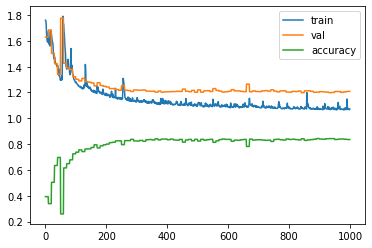

In [6]:
train(seq_model, train_dataloader, test_dataloader, 1000, show_every=10)

In [7]:
tab_model = RandomForestClassifier()
join_model = useSeqTab(seq_model, tab_model, sequences_train, tabular_train, labels)

Join model accuracy: 0.92849
Trained on full data


In [8]:
sequences_test = loadSequential(isTest=True)
tabular_test = loadTabular(cleaned=True, isTest=True)
prediction = getJoinPred(seq_model, join_model, sequences_test, tabular_test)

In [9]:
dumpSubmission(prediction, 'join_sub.csv')